## About

This starter code shows how to read slides and tumor masks from the [CAMELYON16](https://camelyon17.grand-challenge.org/Data/) dataset. It will install [OpenSlide](https://openslide.org/) in Colab (the only non-Python dependency). Note that OpenSlide also includes a [DeepZoom viewer](https://github.com/openslide/openslide-python/tree/master/examples/deepzoom), shown in class. To use that, you'll need to install and run OpenSlide locally on your computer.

### Training data

The original slides and annotations are in an unusual format. I converted a bunch of them for you, so you can read them with OpenSlide as shown in this notebook. This [folder](https://drive.google.com/drive/folders/1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5?usp=sharing) contains all the slides and tumor masks I converted (and these should be *plenty* for your project). If you'd like more beyond this, you'll need to use ASAP as described on the competition website to convert it into an appropriate format. 

Note that even with the starter code, it will take some effort to understand how to work with this data (the various zoom levels, and the coordinate system). Happy to help if you're stuck (please catch me in office hours, or right after class).

### Goals and grading

The goal for your project is to build a thoughtful, end-to-end prototype - not to match the accuracy from the [paper](https://arxiv.org/abs/1703.02442), and not necessarily to use all the available data. To receive an A on this work, your project should (for example):
- Use multiple zoom levels
- Use high-magnification images
- Include several visualizations of your results (both heatmaps showing predictions on individual slides, and other metrics/diagrams you design that are appropriate to communicate how well your model performs).

You are also welcome to propose a custom project of similar scope, happy to chat with you about your ideas anytime.

-----

# COMS4995 Final Project Preprocessing Slides 

In [ ]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
from tqdm.notebook import tqdm
from collections import defaultdict
import tensorflow as tf

### Exploring a Slide and the Coordinate system 
Below I simply imported one slide that Professor Gordon had in the skeleton code. This slide is used, as you will see below to understand the coordinate system, cropping and how to go about zooming.

In [ ]:
# Download an example slide and tumor mask

# Note: the remainder of the training data are in the Google Drive folder linked above.
# You will need to host them on your own, either in Google Drive, or by using
# the cloud provider of your choice.

slide_path = 'tumor_091.tif' # only this file is available
tumor_mask_path = 'tumor_091_mask.tif' # only this file is available

slide_url = 'https://storage.googleapis.com/applied-dl/%s' % slide_path
mask_url = 'https://storage.googleapis.com/applied-dl/%s' % tumor_mask_path

# Download the whole slide image
if not os.path.exists(slide_path):
  !curl -O $slide_url

# Download the tumor mask
if not os.path.exists(tumor_mask_path):
  !curl -O $mask_url

In [ ]:
slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Read WSI from tumor_091.tif with width: 61440, height: 53760
Read tumor mask from tumor_091_mask.tif
Slide includes %d levels 8
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360) downsample factor 16
Level 5, dimensions: (1920, 1680) downsample factor 32
Level 6, dimensions: (960, 840) downsample factor 64
Level 7, dimensions: (480, 420) downsample factor 128


In [ ]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

To start off with, I wanted to see what the slide looks like as a whole.

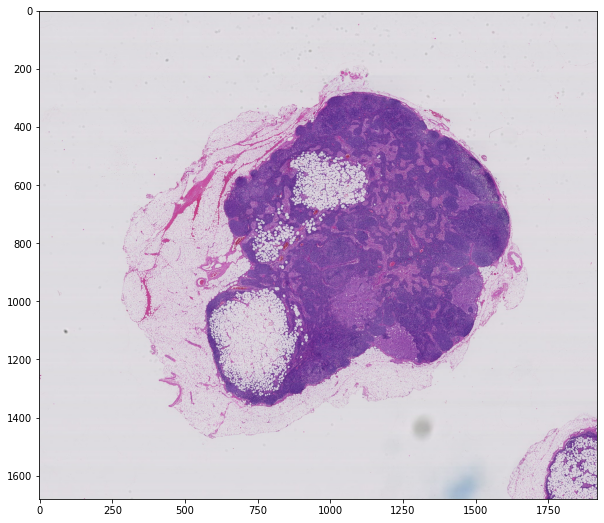

In [ ]:
level = 5
slide_image = read_slide(slide, 
                         x=0, 
                         y=0,  
                         level=level, 
                         width=slide.level_dimensions[level][0], 
                         height=slide.level_dimensions[level][1])

plt.figure(figsize=(10,10))
plt.imshow(slide_image)

Then I began looking into how I would crop the image. As needed for input into InceptionV3, I needed to create 299x299 crops. 

The paper specifies that it uses a 128 stride and labels images based off the center 128x128 area of each crop. Having that overlap between the crops due to the smaller stride most likely helps from overfitting when training the models, as it might deter from the model learning false localized patterns (potentially splotches on the slide or discolorations).

Below at a low zoom level (for memory purposes) I show my way of going about using the coordinate system to get crops with the stride.

32.0


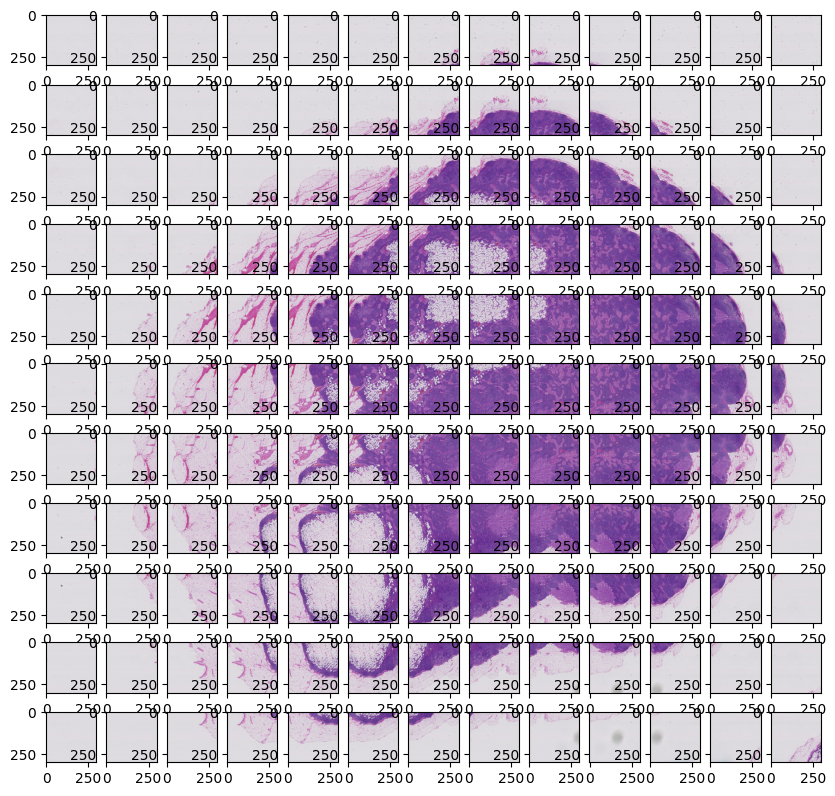

In [ ]:
# Example: read the entire slide at level 5

# Higher zoom levels may not fit into memory.
# You can use the below function to extract regions from higher zoom levels 
# without having to read the entire image into ram.

# Use the sliding window approach discussed in class to collect training
# data for your classifier. E.g., slide a window across the slide (for
# starters, use a zoomed out view, so you're not working with giant images).
# Save each window to disk as an image. To find the label for that image, 
# check to the tissue mask to see if the same region contains cancerous cells.

# Important: this is tricky to get right. Carefully debug your pipeline before
# training your model. Start with just a single image, and a relatively 
# low zoom level.

level = 5
crop_size = 299
stride = 128

'''
The overlap variable essentially tells us how many strides fit in a crop. This 
is useful because whwen get to counting the number of rows and columns, if we count
the number of strides that fit in the image, we would go outside of the images 
border by the number of strides that fit in a crop. Hence we need to make this
correction by subtracting it from the number of rows and cols we compute.
'''
overlap = crop_size // stride 

num_cols = slide.level_dimensions[level][0] // stride - overlap 
num_rows = slide.level_dimensions[level][1] // stride - overlap

print(slide.level_downsamples[level])

plt.figure(figsize=(10,10), dpi=100)
for y_s in range(num_rows):
    for x_s in range(num_cols):

        # Since 
        x_tl = x_s * int(slide.level_downsamples[level]) * x_stride
        y_tl = y_s * int(slide.level_downsamples[level]) * y_stride

        slide_image = read_slide(slide, 
                                x= x_tl, 
                                y= y_tl, 
                                level=level, 
                                width=x_slide, 
                                height=y_slide)
        ax = plt.subplot(num_rows,num_cols,y_s*num_cols+x_s+1)
        plt.imshow(slide_image)

Below I take a look at the mask images:

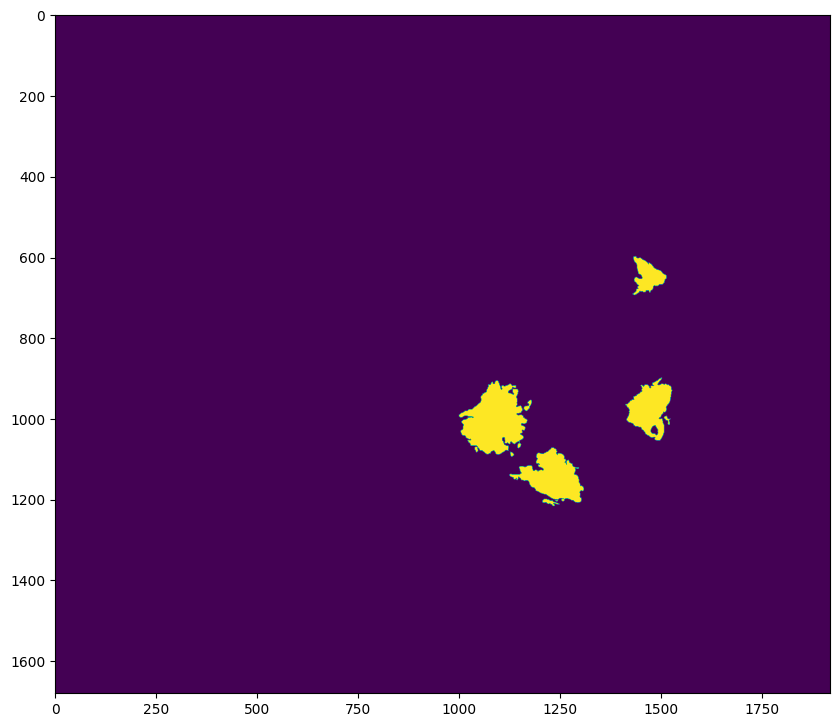

In [ ]:
# Example: read the entire mask at the same zoom level
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=5, 
                        width=slide.level_dimensions[5][0], 
                        height=slide.level_dimensions[5][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image)

Below I show how I go about getting multiple different zoom levels in the coordinate system. I chose 3 different zoom levels for my crop dataset:
Level 2, Level 3 and Level 5. 

I chose Level 2 as my highest zoom level, as I am constrained by the computing resources of colab. I attempted to multithread my crop creation loop; however, am constricted to Colab's 2 CPUs. To create my dataset, it takes about 4 hours to go through all the slides for train and validation. If I were to use a higher zoom, I found that it was feasible to workaround the deadline for the this project. 

I chose zoom level 3, as the next level of zoom as it gives some context to zoom level 2. Finally, I do 5 as well for even more context and skipped 4, just to minimze overlap between the other two zooms. 

In [ ]:
def get_zoom(slide,x_tl,y_tl,from_level,to_level,size):
    '''
    inputs: crop,
            x value (corner of original zoom level),
            y value (corner of original original zoom level),
            from level (original zoom level),
            to level (level we want to convert to),
            size (crop size)
    output: x,y corner of new zoom level such that original zoom
            is in the center of the photo
    '''
    new_x, new_y = x_tl,y_tl

    # To calculate the zoom level I simply go up a level move by half of that
    # level's crop size towards the upper left
    for i in range(from_level,to_level):
        new_x -= (int(slide.level_downsamples[i]) * size // 2)
        new_y -= (int(slide.level_downsamples[i]) * size // 2)
    return new_x,new_y

4.0


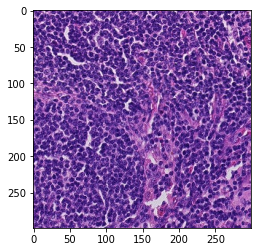

8.0


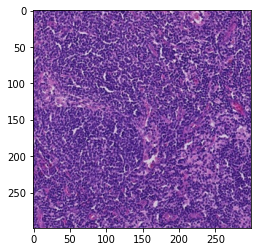

32.0


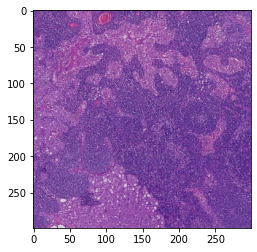

In [ ]:
level = 2
stride = 128
size = 299

y_s = 62
x_s = 39 * 2

# level 2
print(slide.level_downsamples[level])
x_tl = x_s * stride  * int(slide.level_downsamples[level])
y_tl = y_s * stride  * int(slide.level_downsamples[level])
region = read_slide(slide, x=x_tl, y=y_tl , level=level, width=size, height=size)
plt.imshow(region)
plt.show()

# level 3
n_level = level + 1
print(slide.level_downsamples[n_level])
x_nl, y_nl = get_zoom(slide,x_tl,y_tl,level,n_level,size)
region = read_slide(slide, x= x_nl, y= y_nl, level=n_level, width=size, height=size)
plt.imshow(region)
plt.show()

# level 5
nn_level = level + 3
print(slide.level_downsamples[nn_level])
x_nnl, y_nnl = get_zoom(slide,x_nl,y_nl,n_level,nn_level,size)
region = read_slide(slide, x= x_nnl, y= y_nnl, level=nn_level, width=size, height=size)
plt.imshow(region)
plt.show()

In [ ]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

### Creating Dataset

In this seciton I go through the chosen train and val slides and gather their zoom levels and save them to a folder structre that I then zip and save to a GCP bucket.

In terms of the split of train, val, and test slides, there are 21 slides and I allocated the sets as follows from the .txt urls provided by the professor:

* train: 15 slides (~71%)
* validation 2 slides (~9%)
* train: 4 slides (~20%)

(21 total slides minus tumor_38 which did not have any tif files)

I needed to compensate for my lower zoom level with more training data and hence used the full list of slides provided. 

The methods below create train and validation sets only! I made it so that inference and crop processing for prediction happen at runtime. Hence the test slides are processed during evaluation.

In [ ]:
def save_zooms(slide_1,slide_2,slide_3,crop_name,level,n_level,nn_level,dir,label):
    '''
    This function takes in the crops and zoom levels and saves them to jpgs in the 
    file structure
    '''
    img = Image.fromarray(slide_1)
    img.save(os.path.join(dir,label,'lvl' + str(level),crop_name))

    img = Image.fromarray(slide_2)
    img.save(os.path.join(dir,label,'lvl' + str(n_level),crop_name))

    img = Image.fromarray(slide_3)
    img.save(os.path.join(dir,label,'lvl' + str(nn_level),crop_name))

In [ ]:
def in_bounds(x,y,slide):
    '''
    Crops in the outer zooms that end up begin out of bounds would not be useful
    for training, thus this function returns a boolean to see if the coordinates
    are in bounds.
    '''
    return (x >= 0) and (y >= 0) and (x + 299 <= slide.dimensions[0]) and (y + 299 <= slide.dimensions[1])

In [ ]:
def get_crops(slide,tumor_mask,level,dir,filename):
    '''
    inputs: slide, tumor_mask, level,dir (directory wanted to save to), 
            filename (filename of the slide)
    purpose: save all zooms for each crop for a given slide a folder.
             
             structure is as follows:
                /dir
                    /lvl2
                        tumor_i_(x_s)_(y_s).jpg
                        ...
                    /lvl3
                        ...
                    /lvl5
                        ...
    '''

    size = 299
    stride = 128
    overlap = size // stride

    # this is the value added to get the middle 128x128 label region in the crop
    padding = (size - stride) // 2

    num_cols = slide.level_dimensions[level][0]//stride - overlap
    num_rows = slide.level_dimensions[level][1]//stride - overlap

    for y_s in tqdm(range(num_rows)):
        for x_s in range(num_cols):

            # Create default top-left (x,y) value for Level 2
            x_tl = x_s * int(slide.level_downsamples[level]) * stride
            y_tl = y_s * int(slide.level_downsamples[level]) * stride
            
            # Zoom Level 2
            slide_image = read_slide(slide,x= x_tl,y= y_tl,level=level,width=size,height=size)
            tissue_pixels = find_tissue_pixels(slide_image)
            percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0])
            
            # Paper only choses to inference on images if more than 80% of pixels are non-grey
            if percent_tissue > 0.8:   

                # Zoom Level 3         
                n_level = level + 1
                x_nl, y_nl = get_zoom(slide,x_tl,y_tl,level,n_level,size)

                # Zoom Level 5  
                nn_level = level + 3
                x_nnl, y_nnl = get_zoom(slide,x_nl,y_nl,n_level,nn_level,size)

                # Checks if Level 5 is in bounds of the image
                if in_bounds(x_nnl,y_nnl,slide):
                
                    # Get crops for lvl 3,5 and also get mask
                    n_region = read_slide(slide, x= x_nl, y= y_nl, level=n_level, width=size, height=size)
                    nn_region = read_slide(slide, x= x_nnl, y= y_nnl, level=nn_level, width=size, height=size)
                    mask_image = read_slide(tumor_mask,x= x_tl+padding,y= y_tl+padding,level=level,width=stride,height=stride)

                    # names that images will be saved as
                    crop_name = filename + '_'+ str(x_s) + '_' + str(y_s) + '.jpg'

                    mask_image = mask_image[:,:,0]
                    
                    # if any of the values in the mask is positive in the region
                    if np.any(mask_image):
                        save_zooms(slide_image,n_region,nn_region,crop_name,level,n_level,nn_level,dir,'1')
                    else:
                        save_zooms(slide_image,n_region,nn_region,crop_name,level,n_level,nn_level,dir,'0')

In [ ]:
def gather_urls(filename):
    '''
    This function creates a dict of slide name => slide, tumor slide (urls)
    '''
    urls = defaultdict(list)
    with open(filename,'r') as f:
        for line in f.read().splitlines():
            image = line.rsplit('/', 1)[-1][:9]
            if '.tif' in line:
                urls[image].append(line)
    return urls

In [ ]:
def get_slide(url_slide):
    if 'mask' in url_slide[0]:
        slide_path = url_slide[1]
        tumor_mask_path = url_slide[0]

        slide_path_file = slide_path.rsplit('/', 1)[-1]        
        tm_path_file = tumor_mask_path.rsplit('/', 1)[-1]
    else:
        slide_path = url_slide[0]
        tumor_mask_path = url_slide[1]

        slide_path_file = slide_path.rsplit('/', 1)[-1]        
        tm_path_file = tumor_mask_path.rsplit('/', 1)[-1]

    if not os.path.exists(slide_path_file):
        !curl -O $slide_path

    if not os.path.exists(tm_path_file):
        !curl -O $tumor_mask_path

    slide = open_slide(slide_path_file)
    tumor_mask = open_slide(tm_path_file)

    print(slide_path_file)
    print(tm_path_file)
    
    for i in range(len(slide.level_dimensions)-1):
        assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
        assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

    width, height = slide.level_dimensions[7]
    assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
    assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]
    
    return (slide,tumor_mask,slide_path_file,tm_path_file) 

In [ ]:
def create_dataset(urls,level,dir):
    '''
    This function goes through the url dictionary and calls the get_crops function
    for each slide after it is downloaded. Once the crops are created, the slides
    are deleted to save disk space.
    '''
    for image_name,image_array in urls.items():
        slide, tumor_mask, slide_path_file, tm_path_file = get_slide(image_array)
        get_crops(slide,tumor_mask,level,dir,image_name)
        !rm -f $slide_path_file
        !rm -f $tm_path_file

Creating the needed folders below:

In [ ]:
!mkdir train 
!mkdir train/1
!mkdir train/1/lvl2
!mkdir train/1/lvl3
!mkdir train/1/lvl5
!mkdir train/0
!mkdir train/0/lvl2
!mkdir train/0/lvl3
!mkdir train/0/lvl5

!mkdir val 
!mkdir val/1
!mkdir val/1/lvl2
!mkdir val/1/lvl3
!mkdir val/1/lvl5
!mkdir val/0
!mkdir val/0/lvl2
!mkdir val/0/lvl3
!mkdir val/0/lvl5

mkdir: cannot create directory ‘val’: File exists


In [ ]:
LEVEL = 2
train_dir = '/content/train'
test_dir = '/content/test'
val_dir = '/content/val'

urls = gather_urls('wsi-urls.txt')

train_images = list(urls.keys())[:-6]
val_images = list(urls.keys())[-6:-4]
test_images = list(urls.keys())[-4:]

assert len(val_images) == 2
assert len(test_images) == 4

train_urls = {k:urls[k] for k in train_images}
val_urls = {k:urls[k] for k in val_images}
test_urls = {k:urls[k] for k in test_images}

Since the links are broken, the code above sadly does not work as it needs to downlaod directly from a source. Fortunately, it would work with any list of links that is fed in.

In [ ]:
create_dataset(train_urls, LEVEL,train_dir)
create_dataset(val_urls, LEVEL,val_dir)

Printing number of positive and negative images:

In [ ]:
pos = os.path.join('/content/train','1')
neg = os.path.join('/content/train','0')

l = os.listdir(neg) 
number_files_neg = len(l)

l = os.listdir(pos)
number_files_pos = len(l)

print(number_files_neg,number_files_pos)

13753 1053


In [ ]:
!zip -rqq data_4.zip train val

Streaming output truncated to the last 5000 lines.
  adding: val/0/lvl3/tumor_084_50_101.jpg (deflated 0%)
  adding: val/0/lvl3/tumor_091_71_37.jpg (deflated 0%)
  adding: val/0/lvl3/tumor_084_66_106.jpg (deflated 0%)
  adding: val/0/lvl3/tumor_084_30_111.jpg (deflated 0%)
  adding: val/0/lvl3/tumor_091_87_61.jpg (deflated 0%)
  adding: val/0/lvl3/tumor_084_62_76.jpg (deflated 1%)
  adding: val/0/lvl3/tumor_091_84_34.jpg (deflated 0%)
  adding: val/0/lvl3/tumor_084_55_97.jpg (deflated 0%)
  adding: val/0/lvl3/tumor_091_57_24.jpg (deflated 0%)
  adding: val/0/lvl3/tumor_084_86_96.jpg (deflated 0%)
  adding: val/0/lvl3/tumor_084_39_97.jpg (deflated 0%)
  adding: val/0/lvl3/tumor_091_73_37.jpg (deflated 0%)
  adding: val/0/lvl3/tumor_084_34_119.jpg (deflated 0%)
  adding: val/0/lvl3/tumor_084_77_27.jpg (deflated 0%)
  adding: val/0/lvl3/tumor_084_102_53.jpg (deflated 0%)
  adding: val/0/lvl3/tumor_091_76_64.jpg (deflated 0%)
  adding: val/0/lvl3/tumor_091_75_39.jpg (deflated 0%)
  adding:

In [ ]:
!du -sh data_4.zip

3.9G	data_4.zip


And that's it! I then zipped up the slides and then saved them to a GCP bucket.

See you in the training notebook! 👀